In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%capture
!pip uninstall -y lightgbm
!pip install lightgbm

In [6]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
import warnings, gc
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [7]:
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

In [8]:
train = pd.read_feather('/content/drive/MyDrive/comeptition/Amex0824/data/train_data.ftr')
train = train.groupby('customer_ID').tail(1).set_index('customer_ID')
print("The training data begins on {} and ends on {}.".format(train['S_2'].min().strftime('%m-%d-%Y'),train['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the training set and {} features.".format(train.shape[0],train.shape[1]))

test = pd.read_feather('/content/drive/MyDrive/comeptition/Amex0824/data/test_data.ftr')
test = test.groupby('customer_ID').tail(1).set_index('customer_ID')
print("\nThe test data begins on {} and ends on {}.".format(test['S_2'].min().strftime('%m-%d-%Y'),test['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the test set and {} features.".format(test.shape[0],test.shape[1]))

del test['S_2']
gc.collect()

titles=['Delinquency '+str(i).split('_')[1] if i.startswith('D') else 'Spend '+str(i).split('_')[1] 
        if i.startswith('S') else 'Payment '+str(i).split('_')[1]  if i.startswith('P') 
        else 'Balance '+str(i).split('_')[1] if i.startswith('B') else 
        'Risk '+str(i).split('_')[1] for i in train.columns[:-1]]
cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
test.columns=titles[1:]
titles.append('Target')
train.columns=titles

The training data begins on 03-01-2018 and ends on 03-31-2018.
There are 458,913 customers in the training set and 190 features.

The test data begins on 04-01-2019 and ends on 10-31-2019.
There are 924,621 customers in the test set and 189 features.


In [9]:
target=train.Target.value_counts(normalize=True)
target.rename(index={1:'Default',0:'Paid'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

In [10]:
target=pd.DataFrame(data={'Default':train.groupby('Spend 2')['Target'].mean()*100})
target['Paid']=np.abs(train.groupby('Spend 2')['Target'].mean()-1)*100
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Paid, name='Paid',
                     text=target.Paid, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Default, name='Default',
                     text=target.Default, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(template=temp,title='Distribution of Default by Day', 
                  barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

In [11]:
plot_df=train.reset_index().groupby('Spend 2')['customer_ID'].nunique().reset_index()
fig=go.Figure()
fig.add_trace(go.Scatter(x=plot_df['Spend 2'], 
                         y=plot_df['customer_ID'], mode='lines',
                         line=dict(color=pal[0], width=3), 
                         hovertemplate = ''))
fig.update_layout(template=temp, title="Frequency of Customer Statements", 
                  hovermode="x unified", width=800,height=500,
                  xaxis_title='Statement Date', yaxis_title='Number of Statements Issued')
fig.show()
del train['Spend 2']

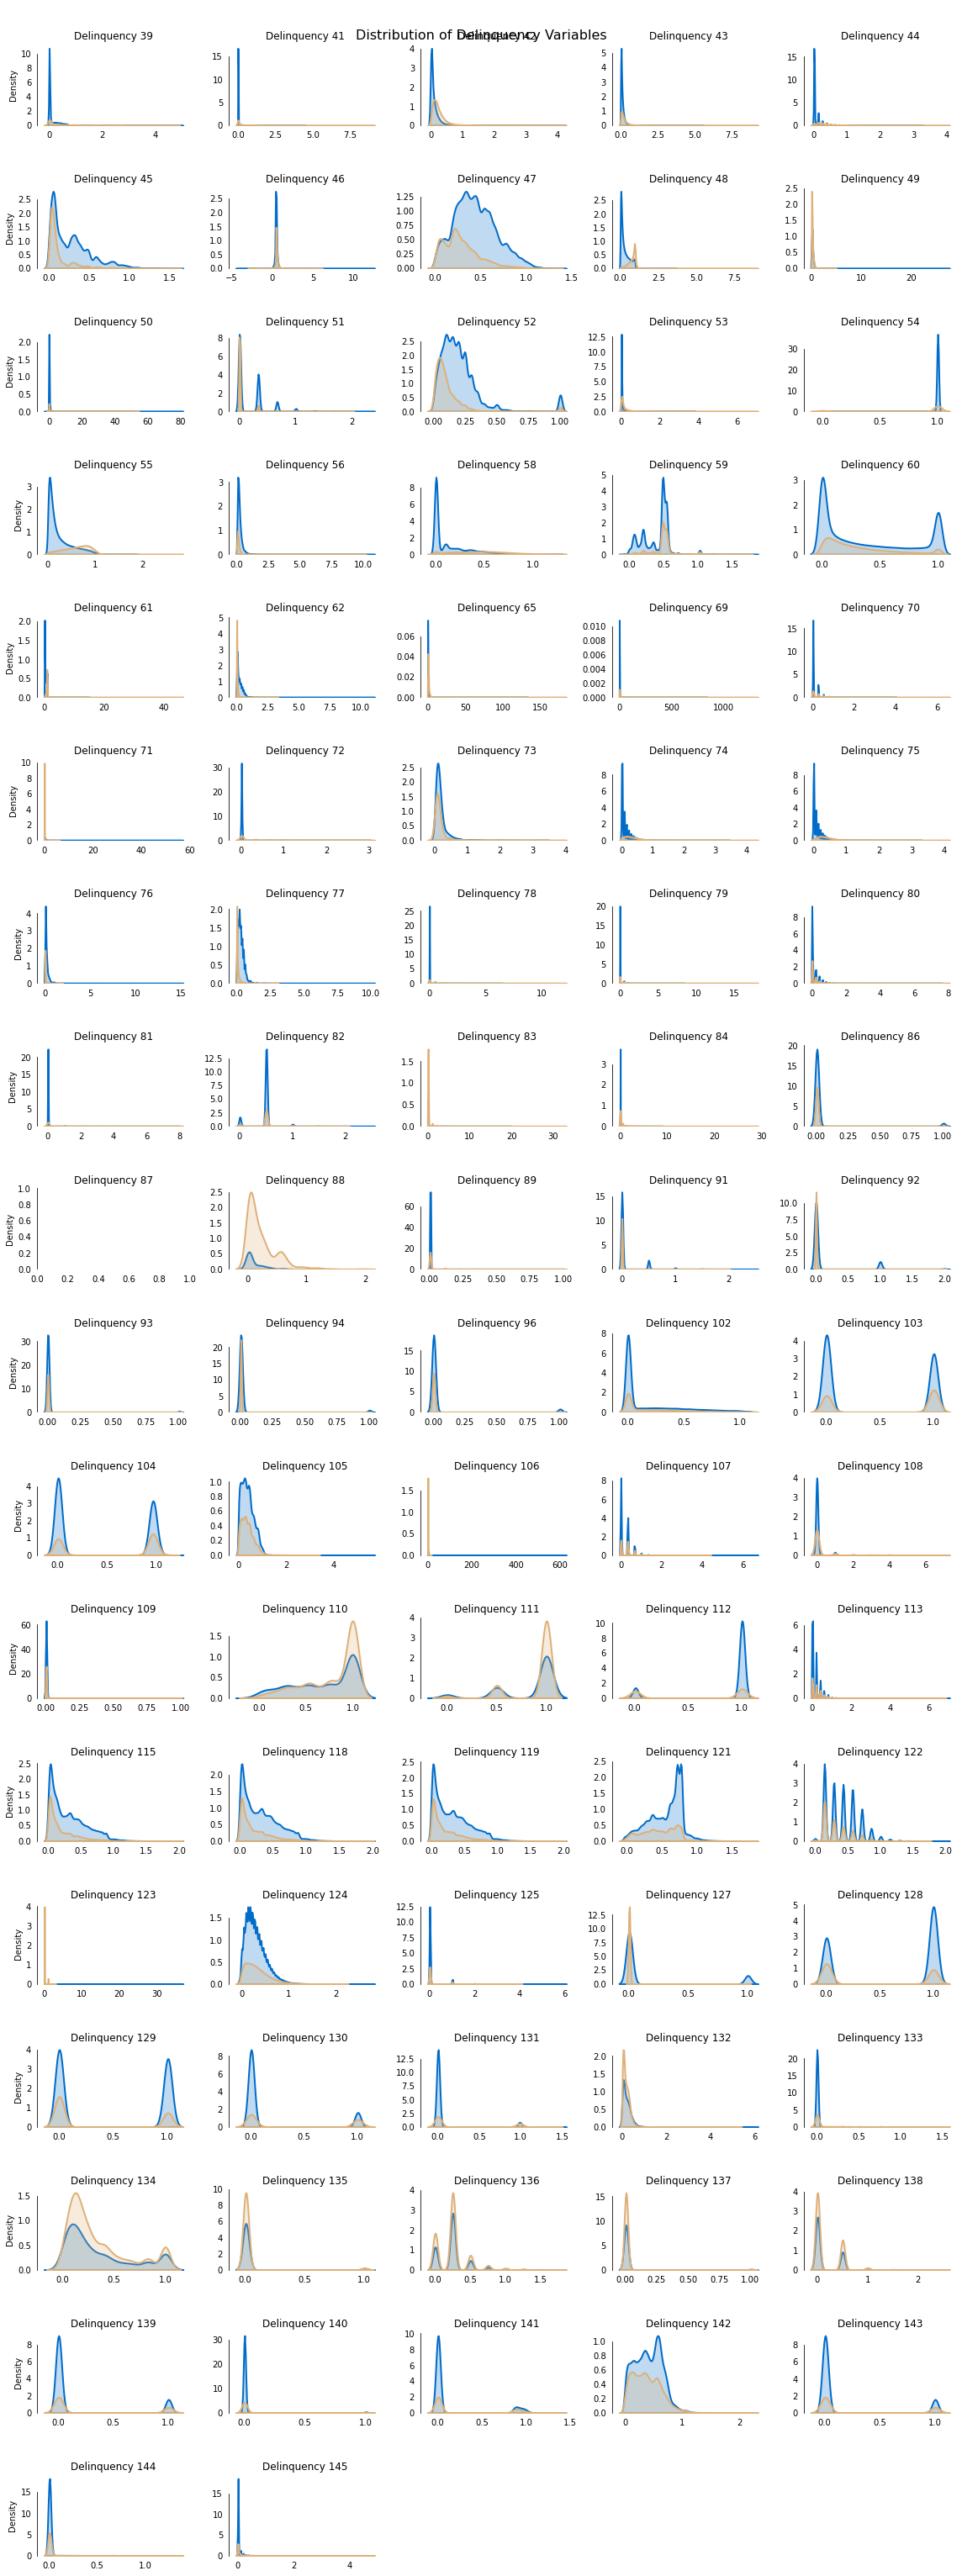

In [12]:
cols=[col for col in train.columns if (col.startswith(('D','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

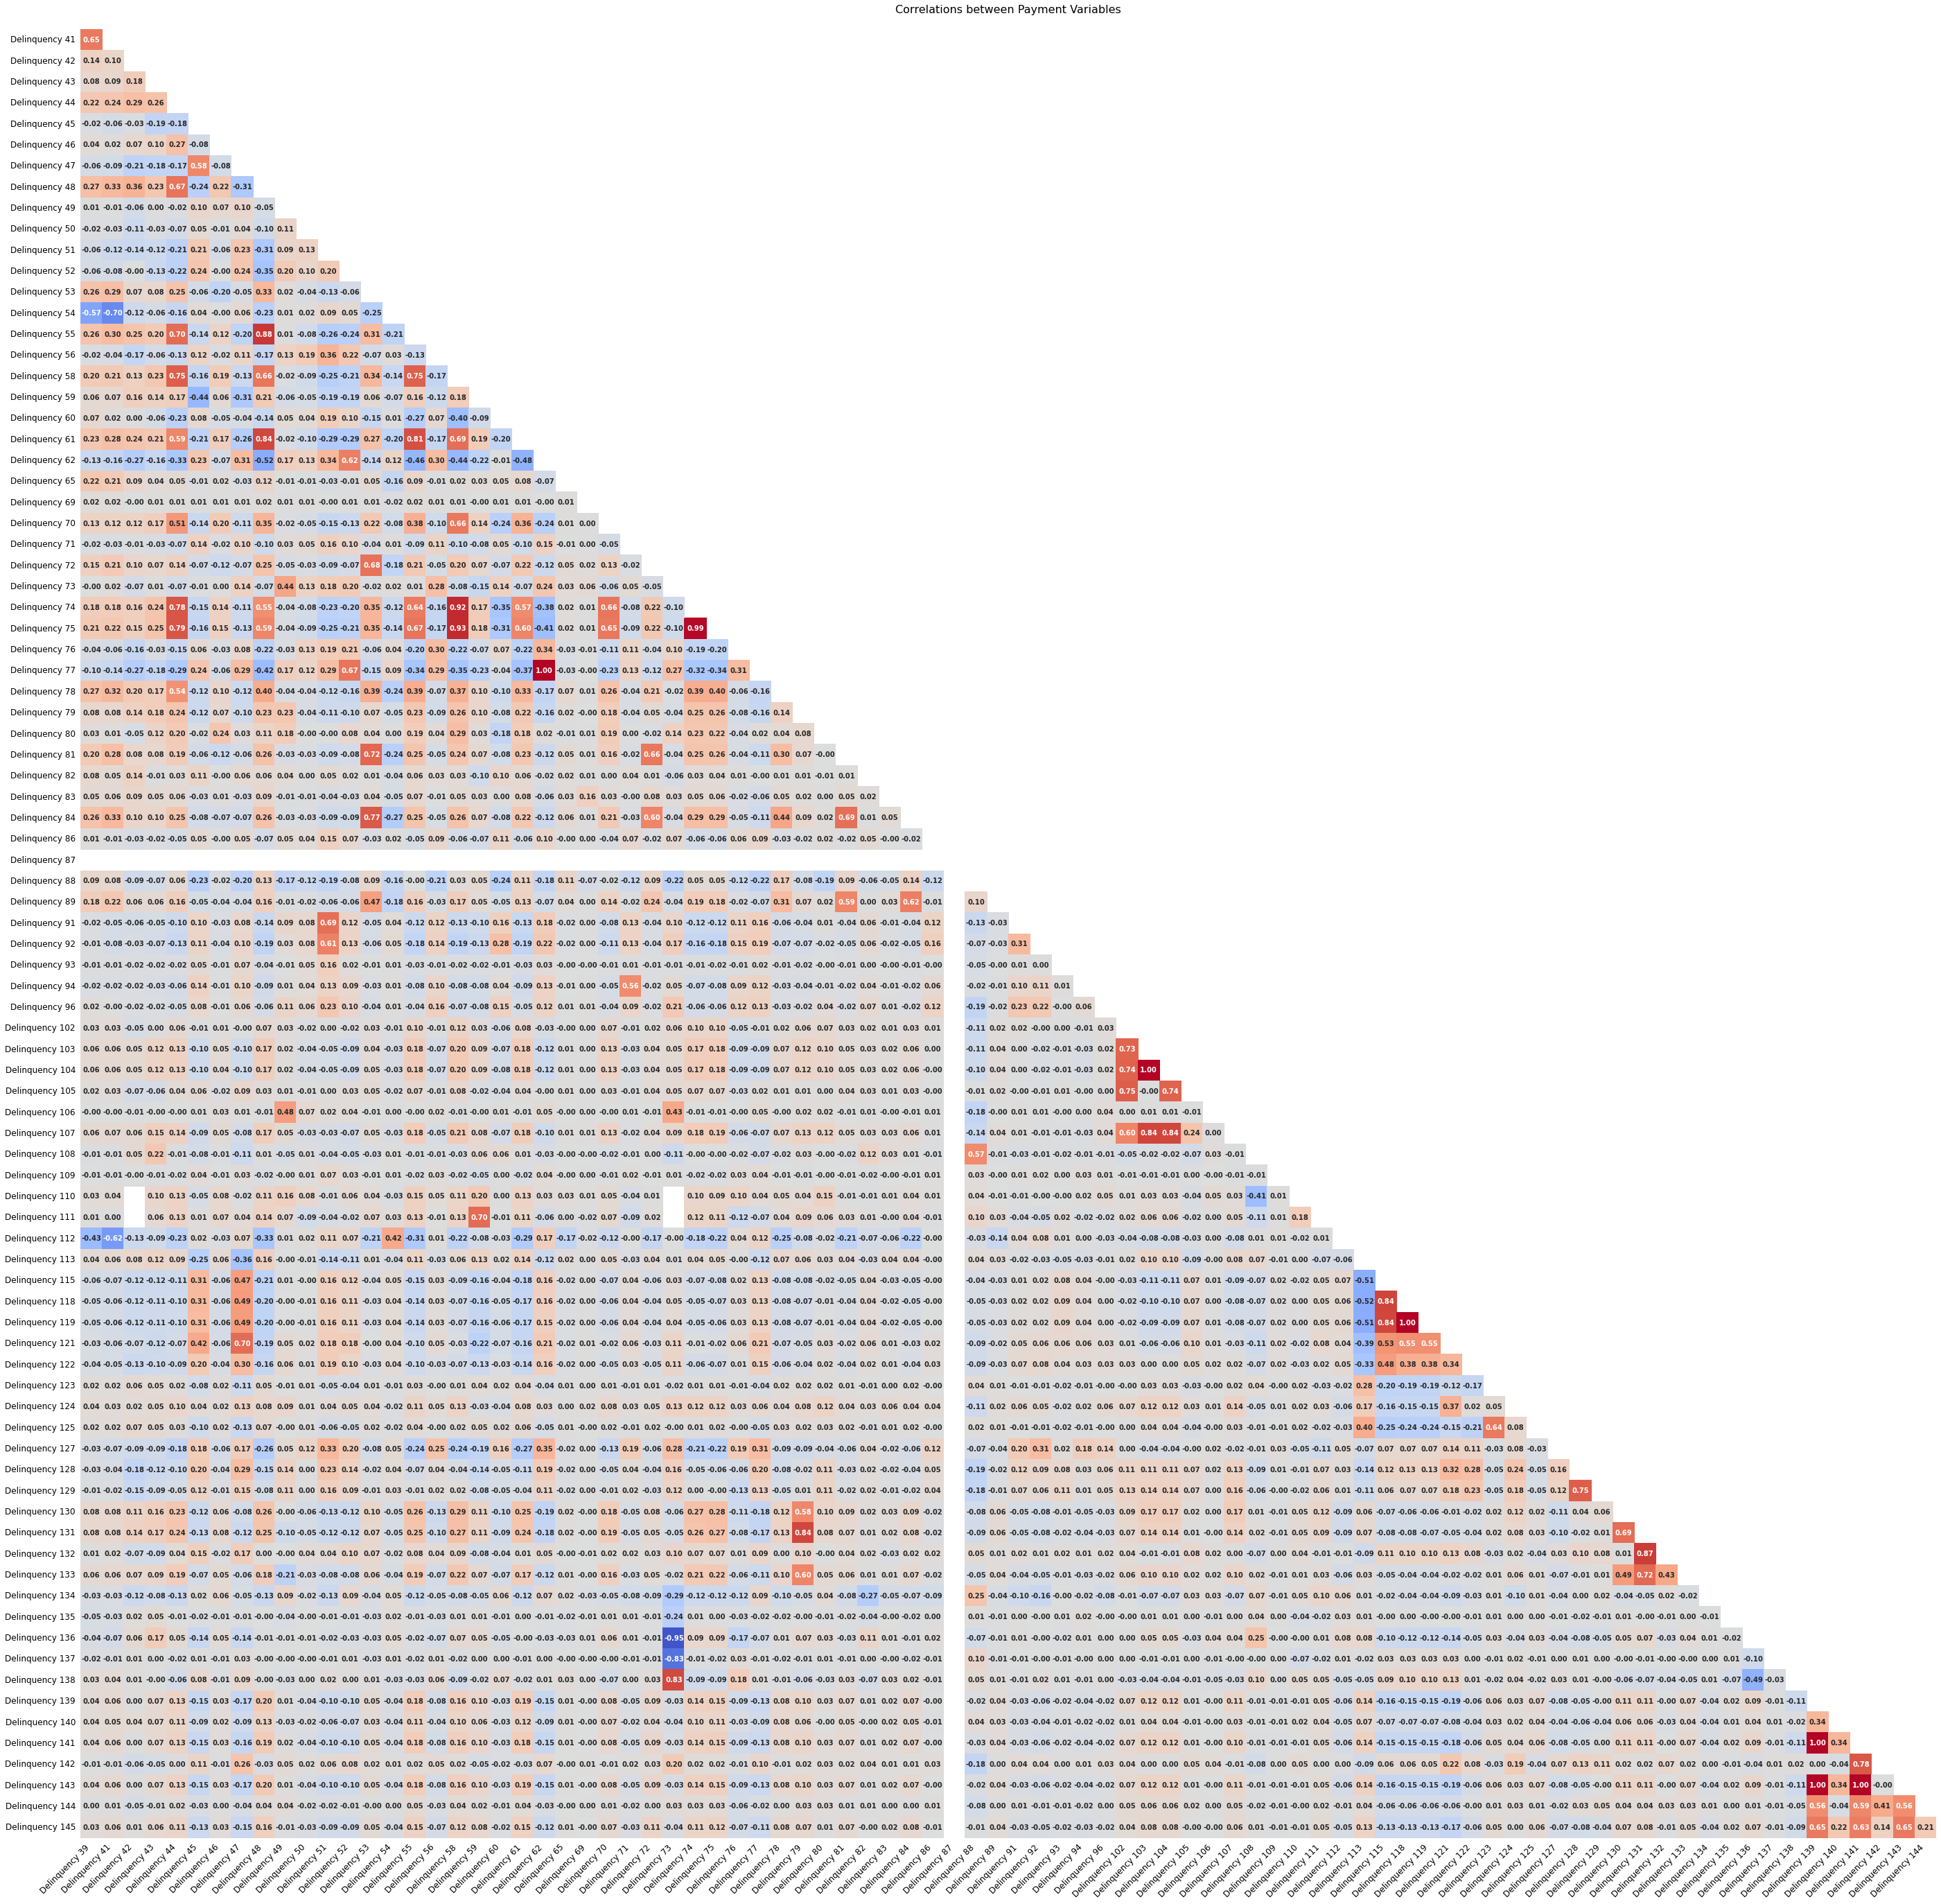

In [13]:
corr=plot_df.iloc[:,:-1].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

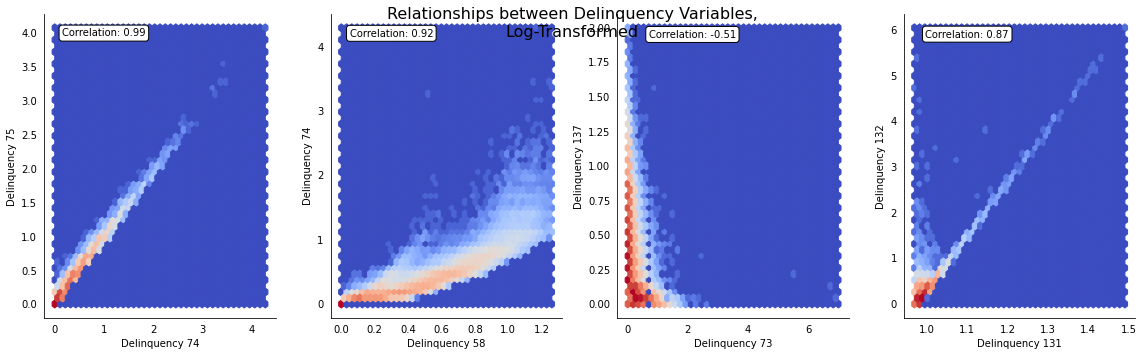

In [14]:
fig, ax = plt.subplots(1,4, figsize=(16,5))
fig.suptitle('Relationships between Delinquency Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Delinquency 74', y='Delinquency 75', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].set(xlabel='Delinquency 74',ylabel='Delinquency 75')
ax[0].text(1, 4, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 74','Delinquency 75']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].hexbin(x='Delinquency 58', y='Delinquency 74', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].set(xlabel='Delinquency 58',ylabel='Delinquency 74')
ax[1].text(0.3, 4.2, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 58','Delinquency 74']].corr().iloc[1,0]),
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].hexbin(x='Delinquency 113', y='Delinquency 115', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].set(xlabel='Delinquency 73',ylabel='Delinquency 137')
ax[2].text(2.15, 1.95, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 113','Delinquency 115']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[3].hexbin(x='Delinquency 131', y='Delinquency 132', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[3].set(xlabel='Delinquency 131',ylabel='Delinquency 132')
ax[3].text(1.1, 5.9, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 131','Delinquency 132']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
for i in range(4):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

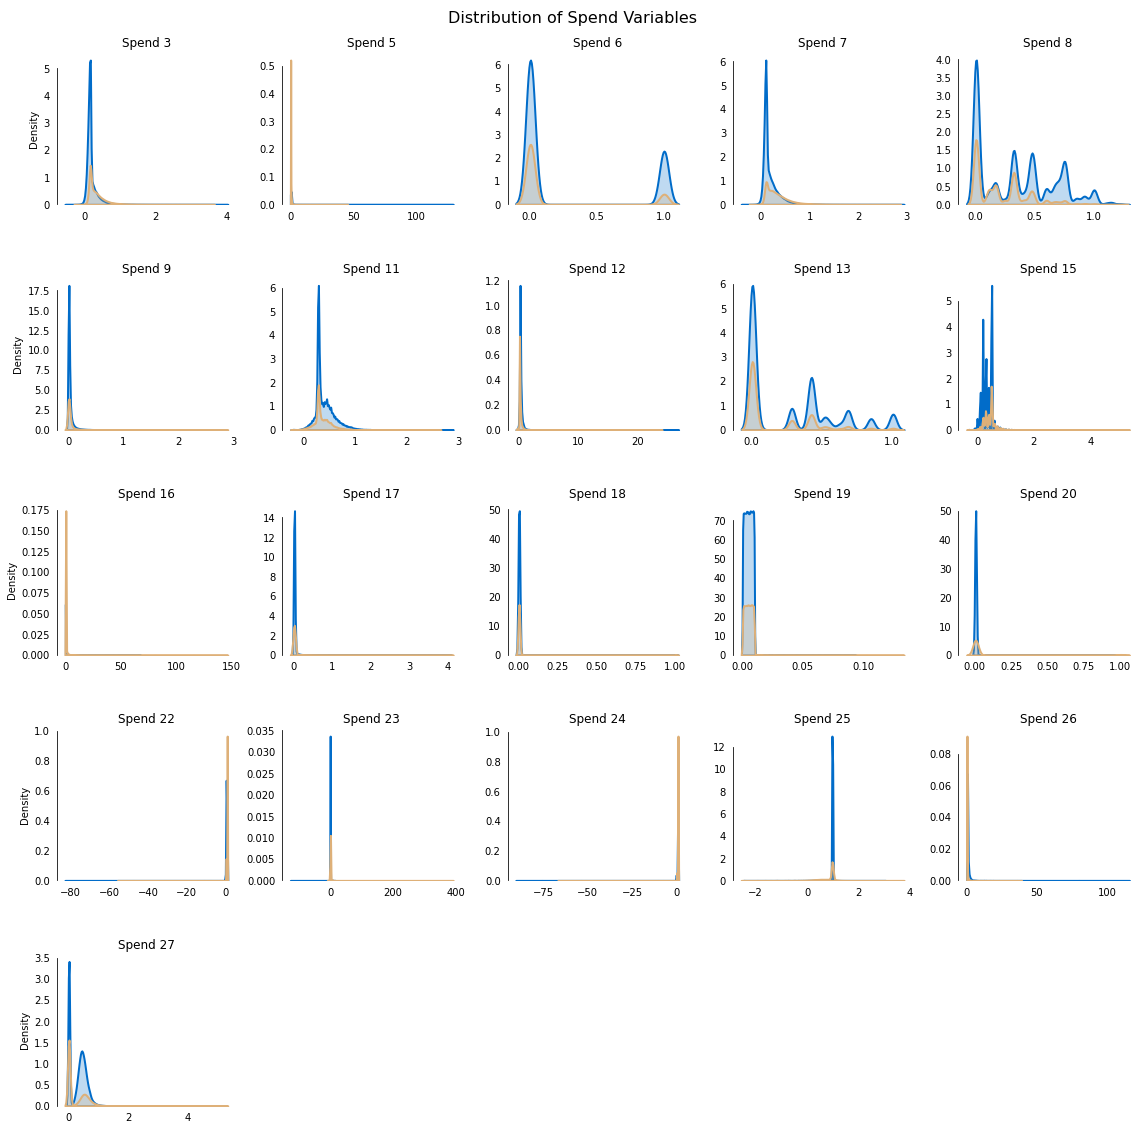

In [15]:
cols=[col for col in train.columns if (col.startswith(('S','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

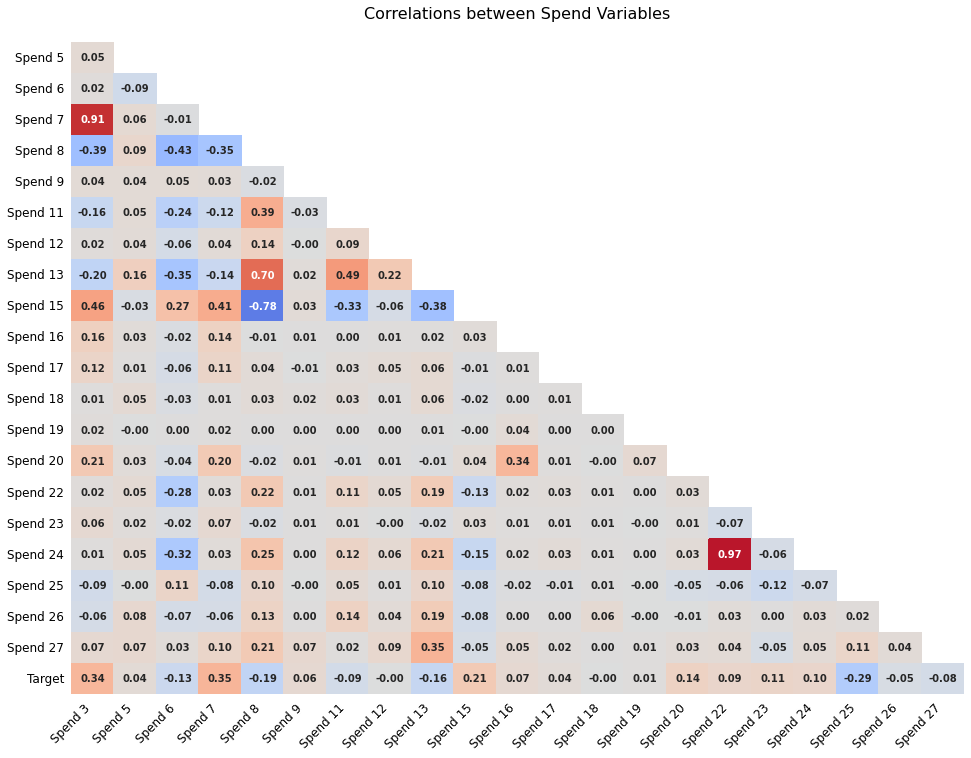

In [16]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(16,12))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
fig.show()

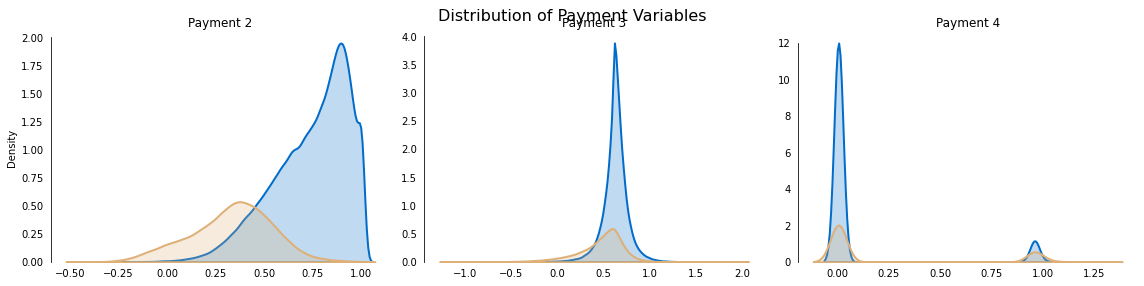

In [17]:
cols=[col for col in train.columns if (col.startswith(('P','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Distribution of Payment Variables',fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(x=col, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[i])
    ax[i].tick_params(left=False,bottom=False)
    ax[i].set(title='{}'.format(col), xlabel='', ylabel=('Density' if i==0 else ''))
handles, _ = ax[0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 1))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

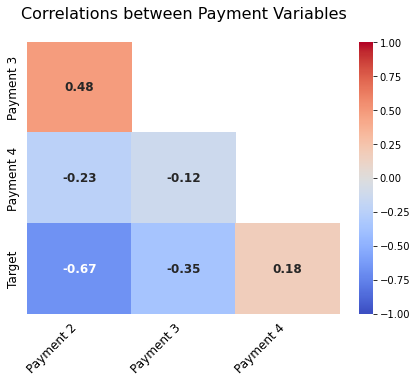

In [18]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'})
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

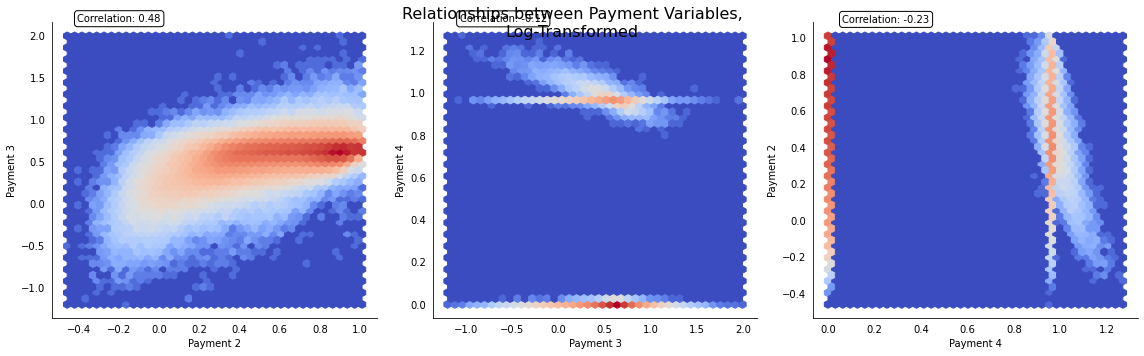

In [19]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relationships between Payment Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Payment 2', y='Payment 3', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(-.2,2.2, 'Correlation: {:.2f}'.format(plot_df[['Payment 2','Payment 3']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='Payment 2',ylabel='Payment 3')
ax[1].hexbin(x='Payment 3', y='Payment 4', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(-.6,1.35, 'Correlation: {:.2f}'.format(plot_df[['Payment 3','Payment 4']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='Payment 3',ylabel='Payment 4')
ax[2].hexbin(x='Payment 4', y='Payment 2', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(.25,1.1, 'Correlation: {:.2f}'.format(plot_df[['Payment 4','Payment 2']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='Payment 4',ylabel='Payment 2')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

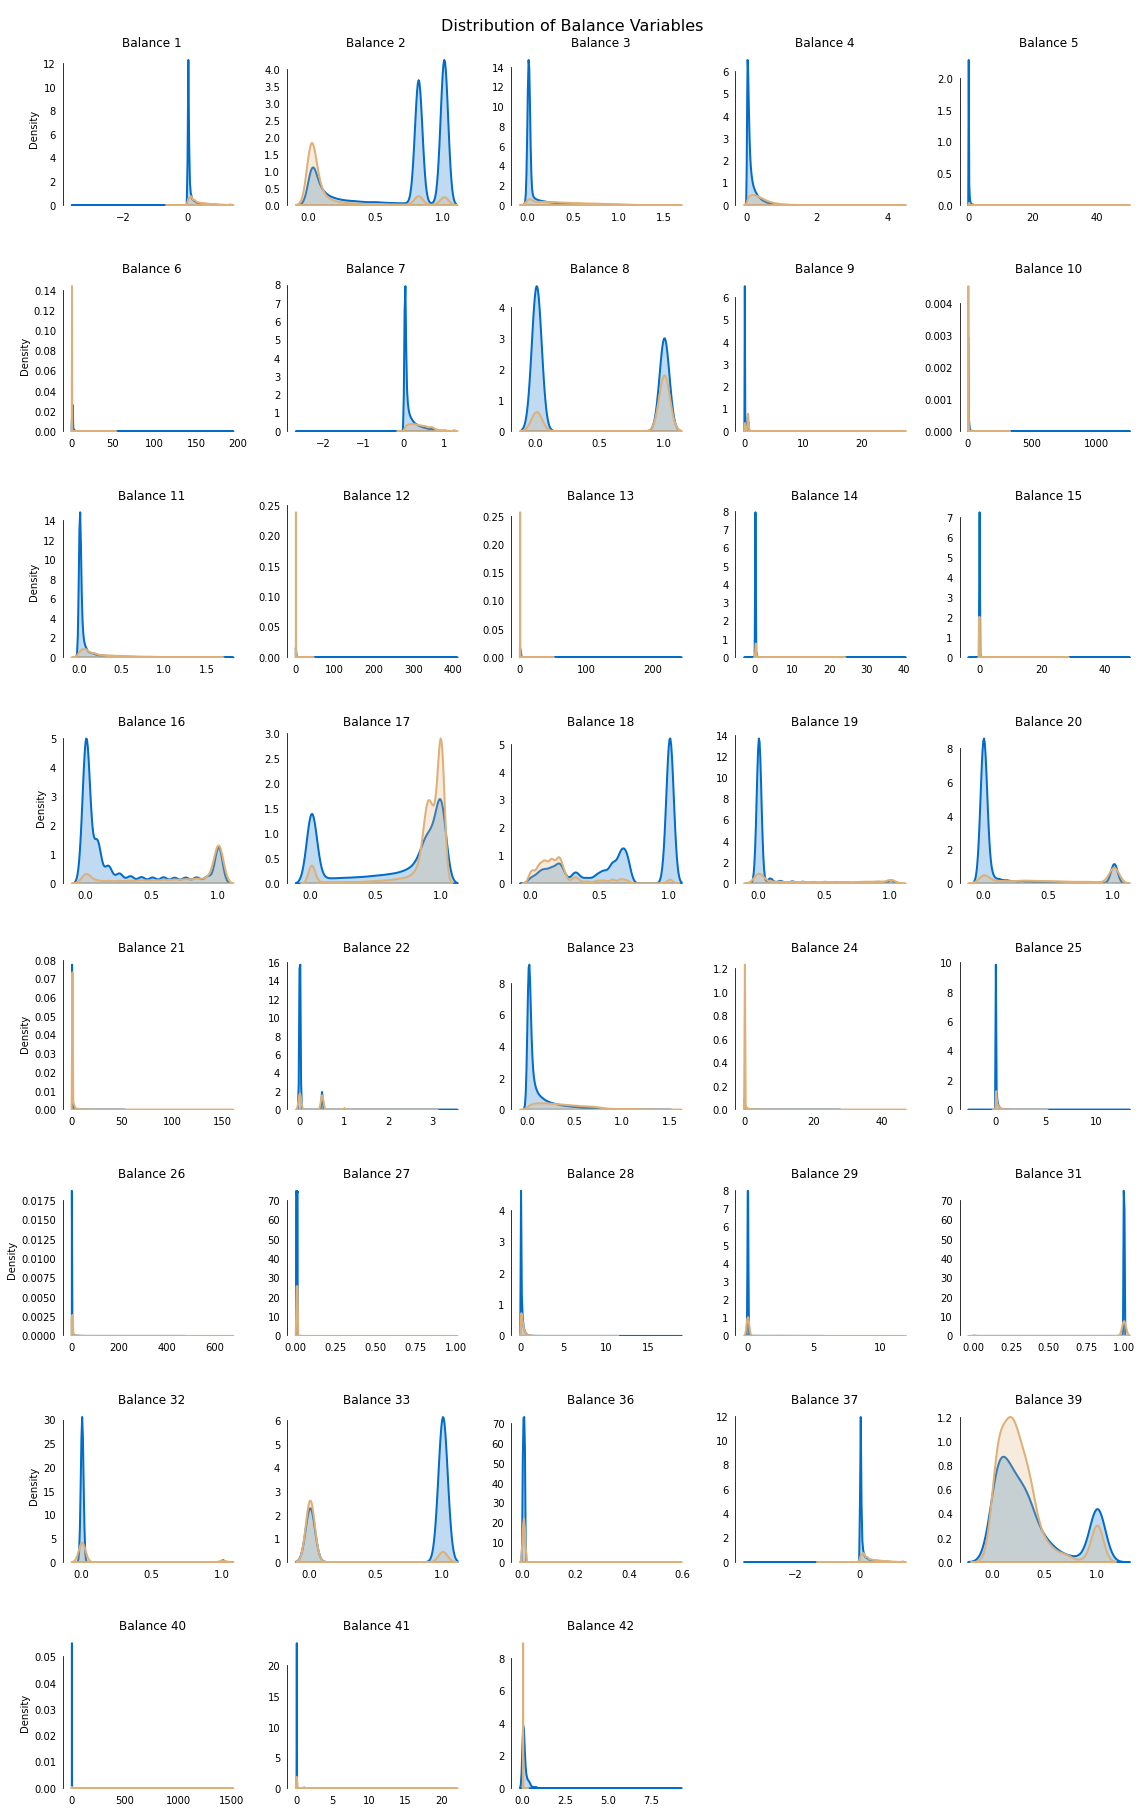

In [20]:
cols=[col for col in train.columns if (col.startswith(('B','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(8,5, figsize=(16,32))
fig.suptitle('Distribution of Balance Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[7,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


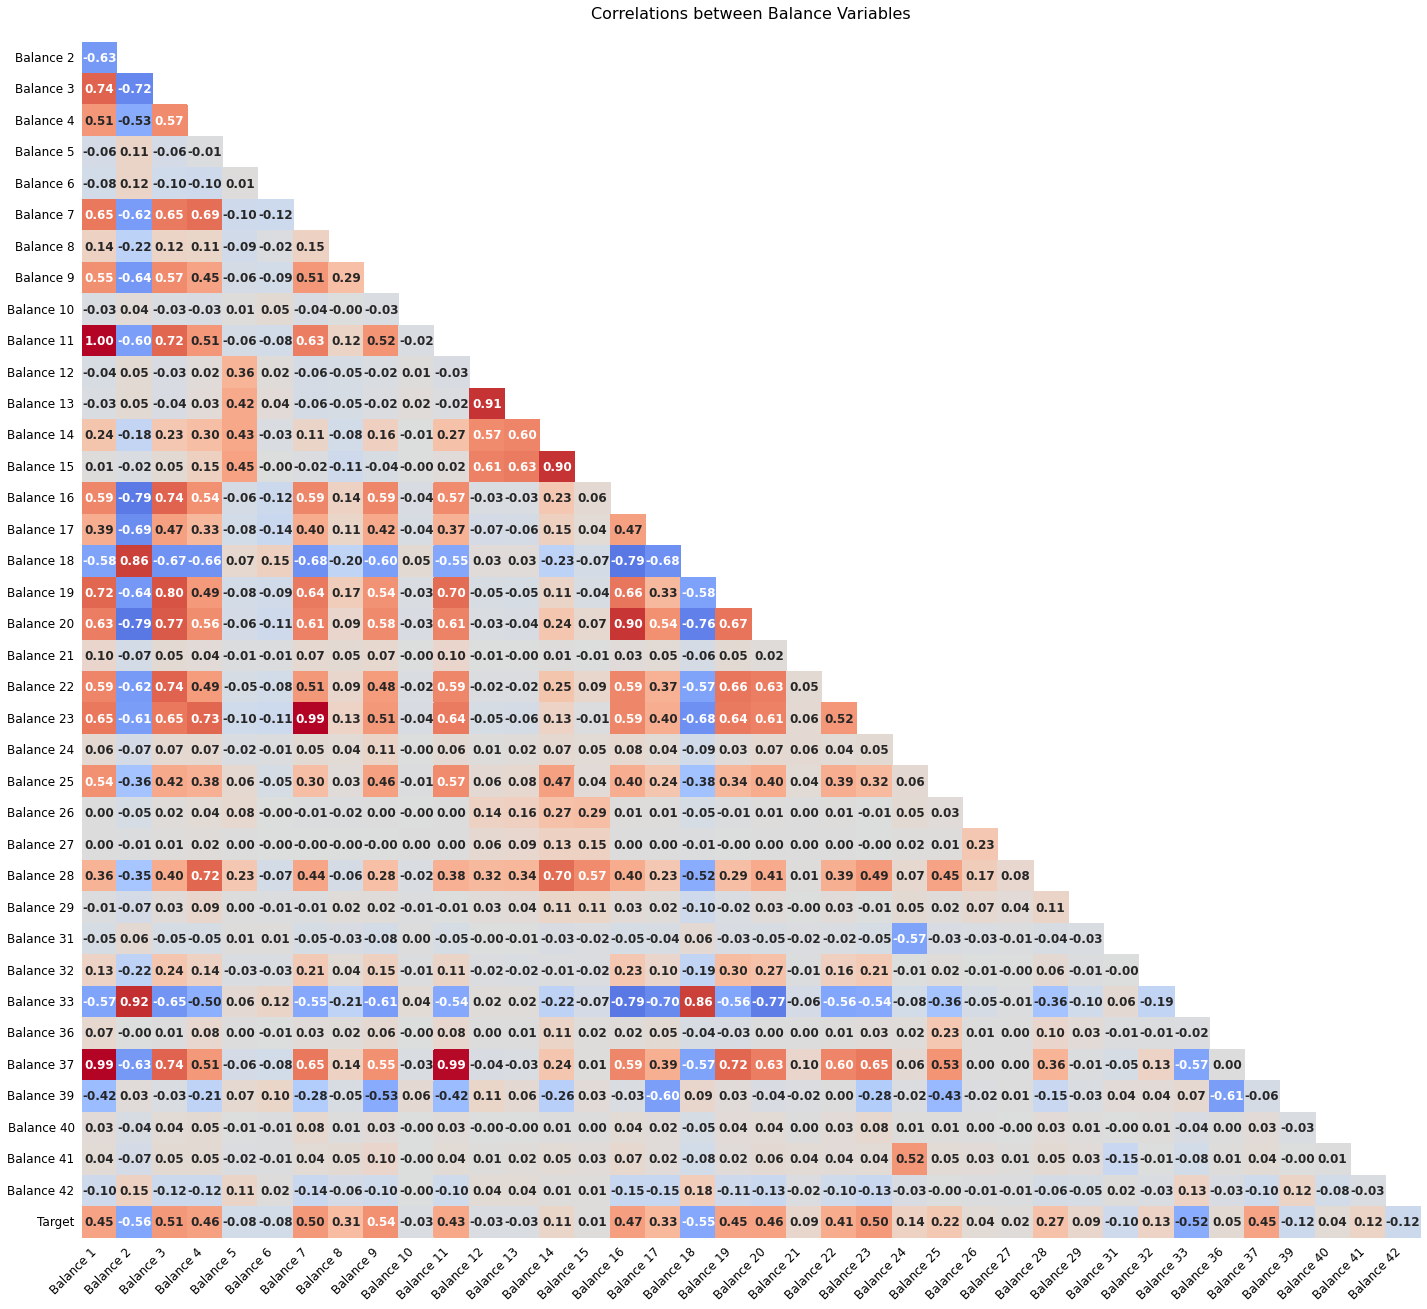

In [21]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,22))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Balance Variables\n', fontsize=16)
fig.show()

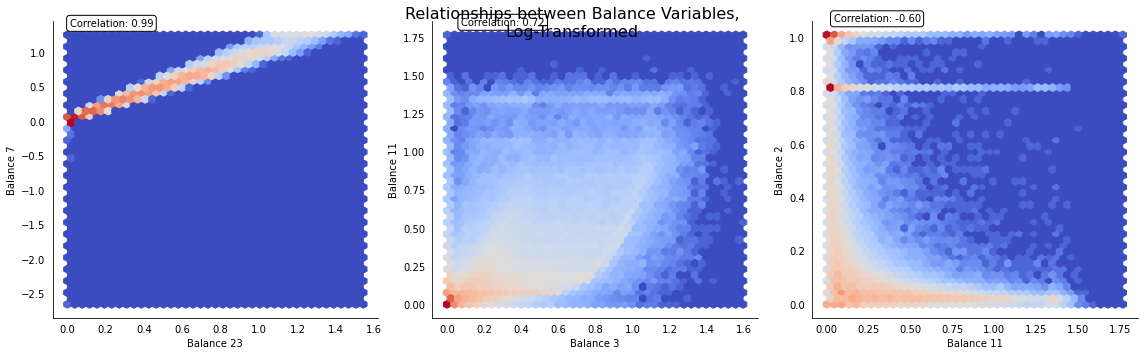

In [22]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relationships between Balance Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Balance 23', y='Balance 7', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(.23,1.42, 'Correlation: {:.2f}'.format(plot_df[['Balance 23','Balance 7']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='Balance 23',ylabel='Balance 7')
ax[1].hexbin(x='Balance 3', y='Balance 11', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(.3,1.85, 'Correlation: {:.2f}'.format(plot_df[['Balance 3','Balance 11']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='Balance 3',ylabel='Balance 11')
ax[2].hexbin(x='Balance 11', y='Balance 2', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(.3,1.07, 'Correlation: {:.2f}'.format(plot_df[['Balance 11','Balance 2']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='Balance 11',ylabel='Balance 2')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

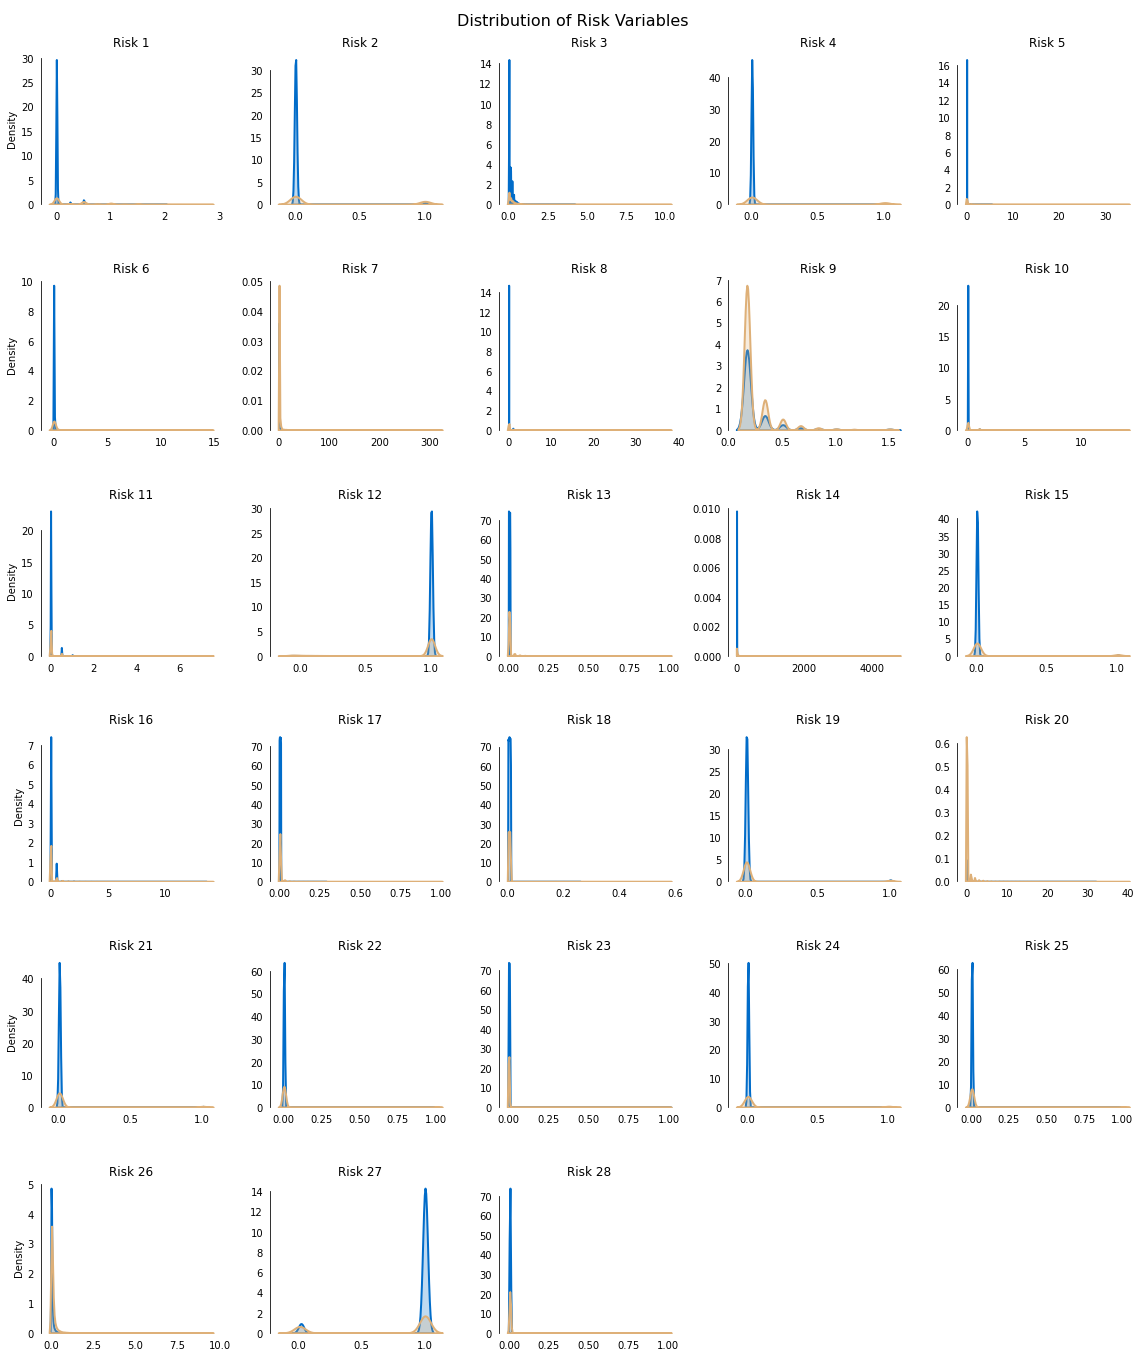

In [23]:
cols=[col for col in train.columns if (col.startswith(('R','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(6,5, figsize=(16,24))
fig.suptitle('Distribution of Risk Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[5,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

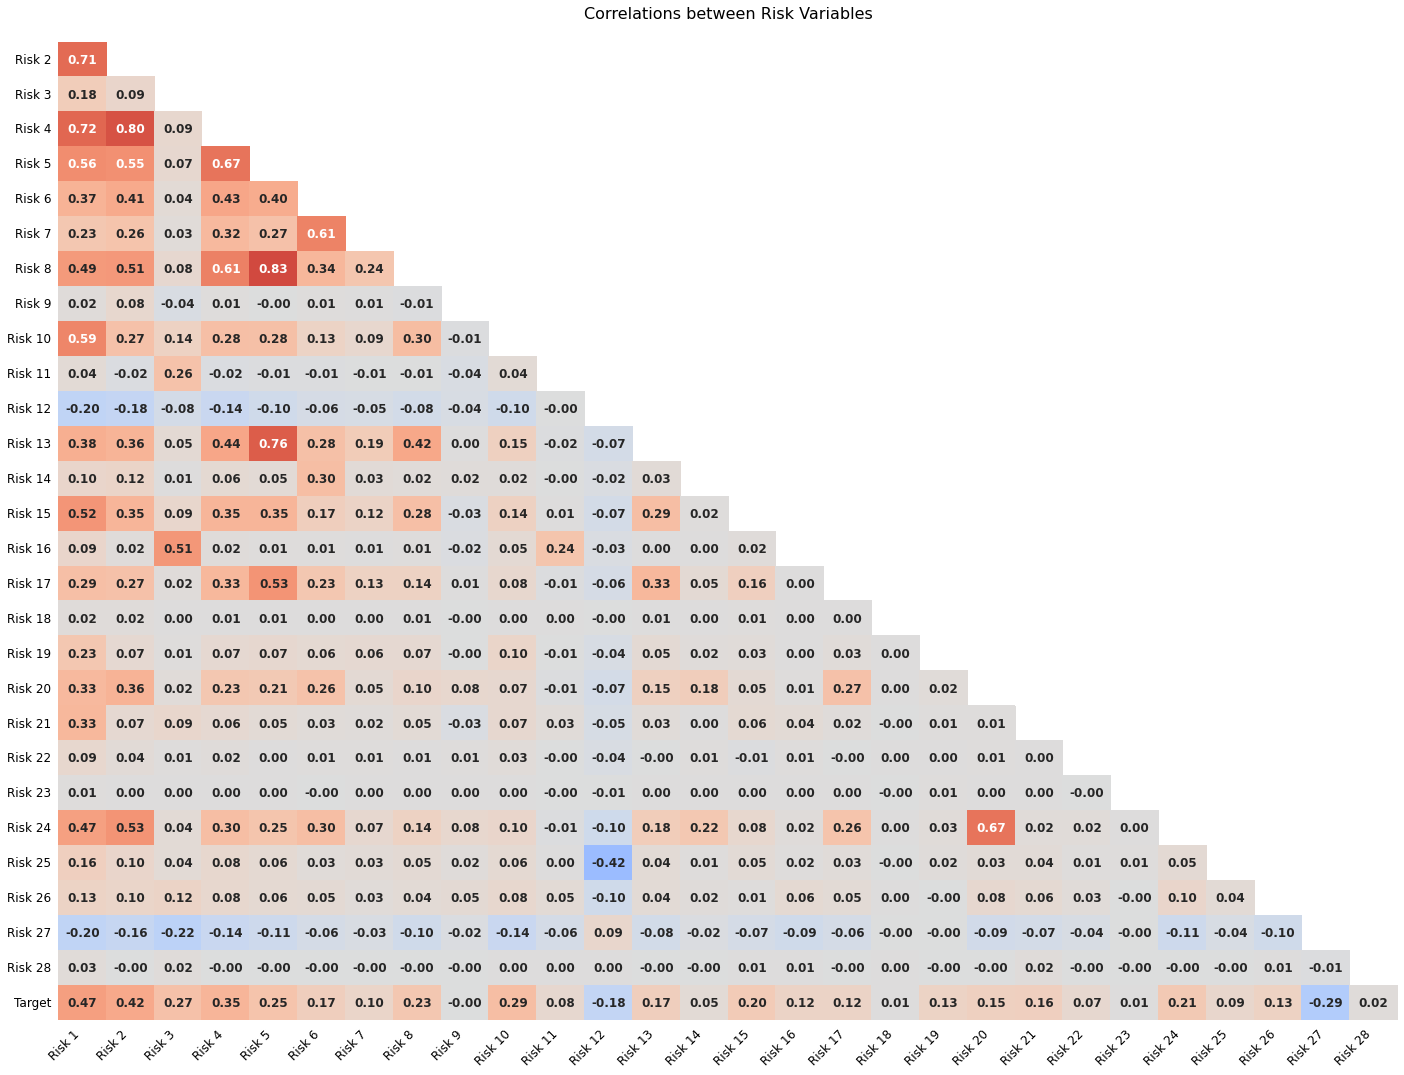

In [24]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,18))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Risk Variables\n', fontsize=16)
fig.show()

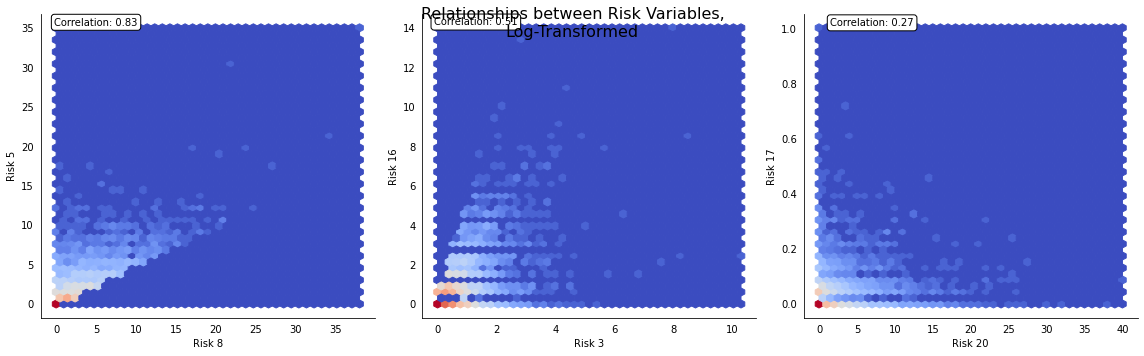

In [25]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relationships between Risk Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Risk 8', y='Risk 5', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(5,35.7, 'Correlation: {:.2f}'.format(plot_df[['Risk 8','Risk 5']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='Risk 8',ylabel='Risk 5')
ax[1].hexbin(x='Risk 3', y='Risk 16', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(1.3,14.3, 'Correlation: {:.2f}'.format(plot_df[['Risk 3','Risk 16']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='Risk 3',ylabel='Risk 16')
ax[2].hexbin(x='Risk 20', y='Risk 17', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(7,1.02, 'Correlation: {:.2f}'.format(plot_df[['Risk 20','Risk 17']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='Risk 20',ylabel='Risk 17')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()